## Import модулей

In [683]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Синтетические данные

Функции для генерации данных

In [684]:
# функция создания одномерных данных
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)

    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)

    if random_x:
        x = np.sort(np.random.rand(N))*x_max
    else:
        x = np.linspace(0,x_max,N)

    y_true = np.array([])

    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))

    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [685]:
# создание функции для визуализации данных
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

# Линейная зависимость

Добавлен шум и увеличено количество точек

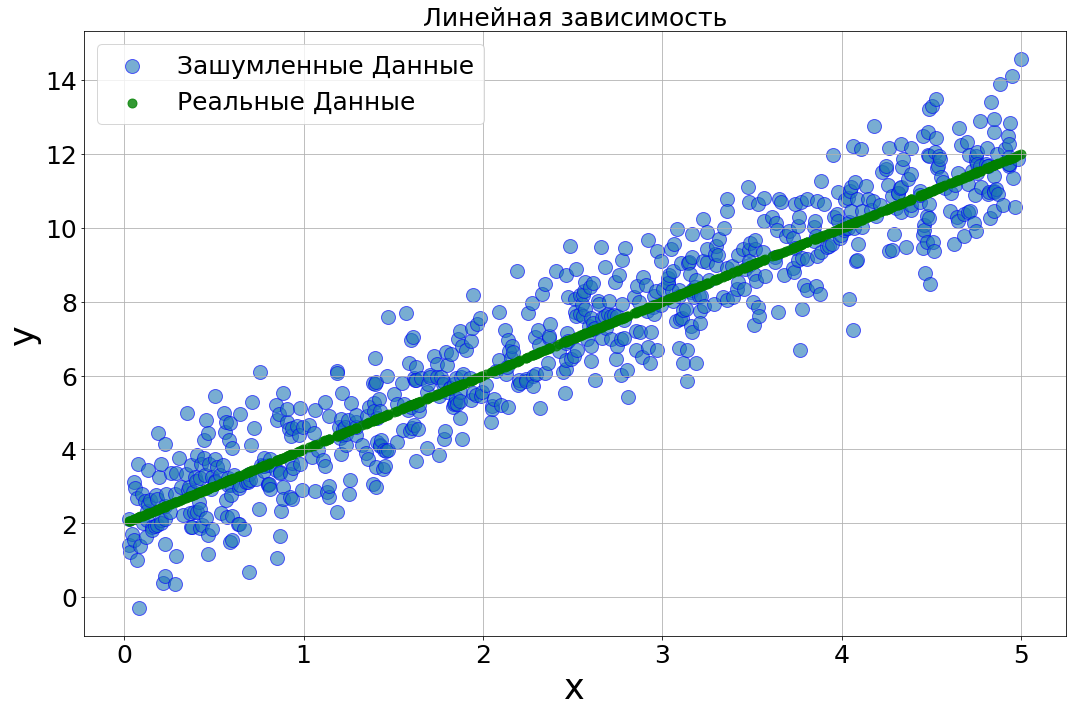

In [686]:
noise_power = 1 # коэффицент зашумления
y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 700,
                       x_max =5,
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

## Линейная регрессия

Разделение на тестовую и тренировочную выборки

In [687]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=50, shuffle=True,):
    if random_state: np.random.seed(random_state)

    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)

    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None

    if train_size is None or train_size > size: train_size = size

    if (train_size<= 1): train_size *= size

    if test_size is not None:
        if test_size<= 1: test_size *= size
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze()
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )


x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (140, 1) (140,) (210, 1) (210,)
(489, 1) (489,) (211, 1) (211,)


Выделение тренировочной и тестовой выборки

In [688]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(489, 1) (489,) (211, 1) (211,)


Класс для линейной регрессии

In [689]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)

        self.n_batches = n_batches

        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)

    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])

        if self.bias is None:
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs):
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()

    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## Тестирование

In [690]:
reg = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
reg.fit(x_train, y_train)

Функция потерь

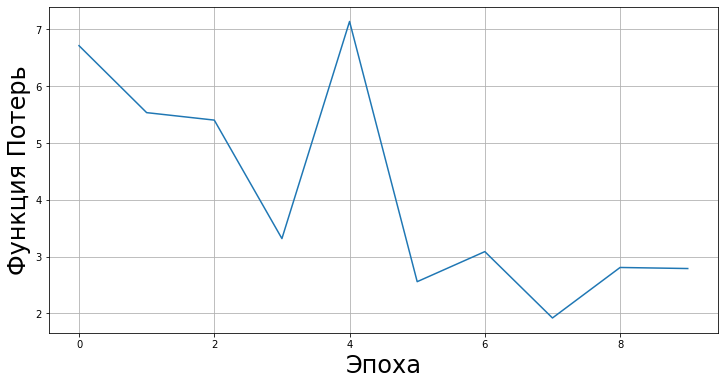

In [691]:
reg.plot_cost()

In [692]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

Рисуем график

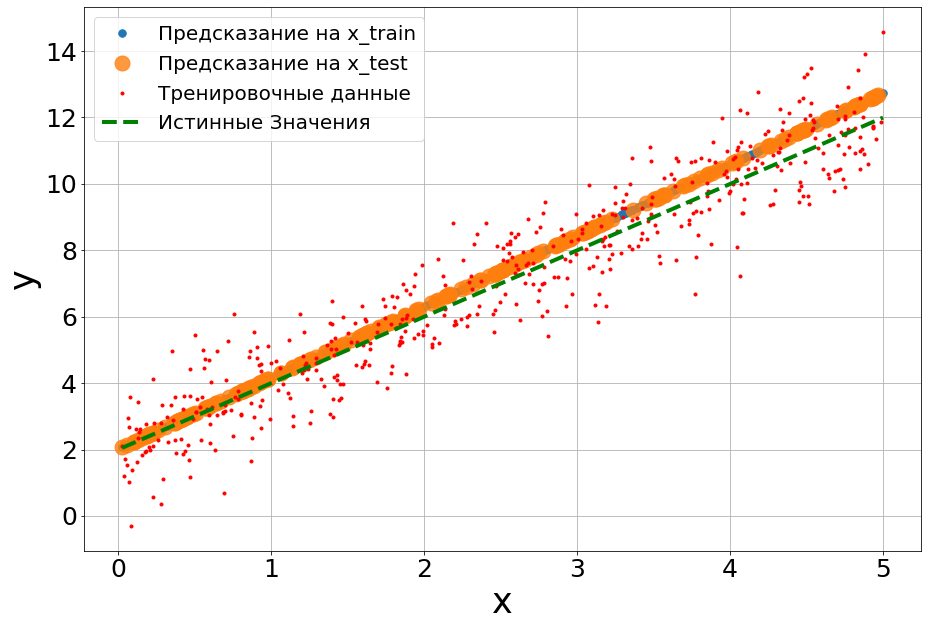

In [693]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, reg)

### Вывод

Из примера видно, что на данных с большим шумом значения потерь уменьшаются медленнее и нестабильнее, чем на данных с маленьким шумом, но по итогу модель приходить к точным предсказаниям.


## Полиномиальная зависимость

Изменим набор данных, уменьшим максимум x и добавим больше шума

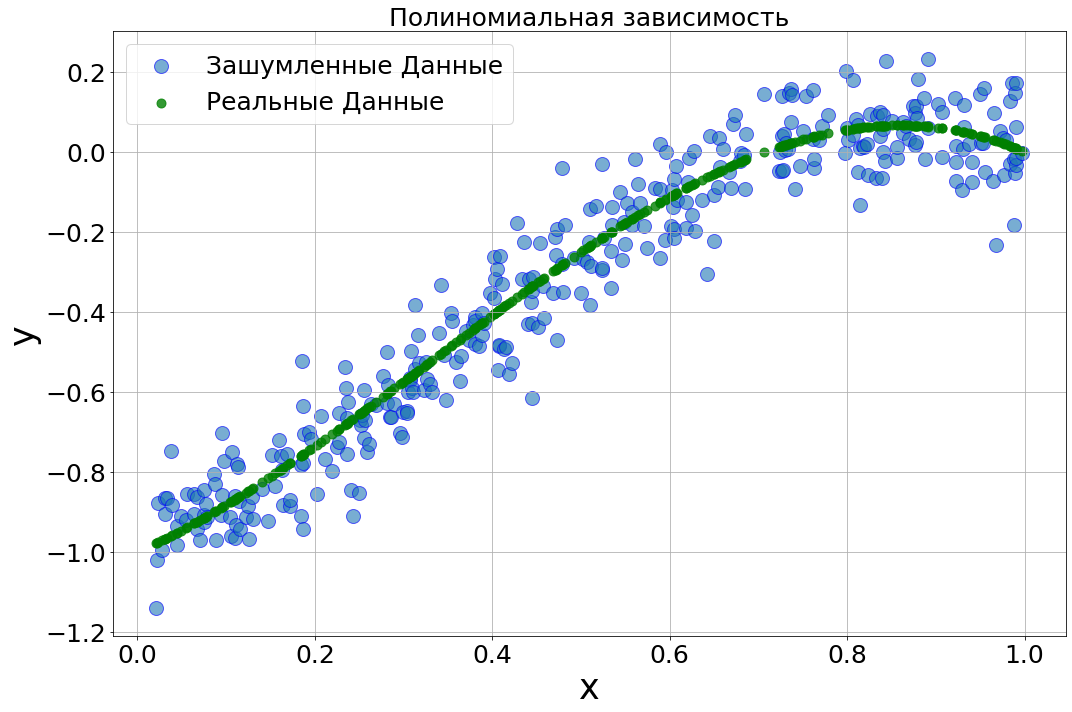

In [694]:
noise_power = 0.09

y, y_true, x = dataset(a = [1,2,-2], b = -1,
                       f = None,  N = 350,
                       x_max =1,
                       noise_power = noise_power,
                       seed = 45)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

Создание полинома 5 степени

In [695]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

In [696]:
x_ = to_polynom(x, order = 5)
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

Используем линейную регрессию

In [697]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [698]:
regr_poly.fit(x_train, y_train)

Смотрим результат

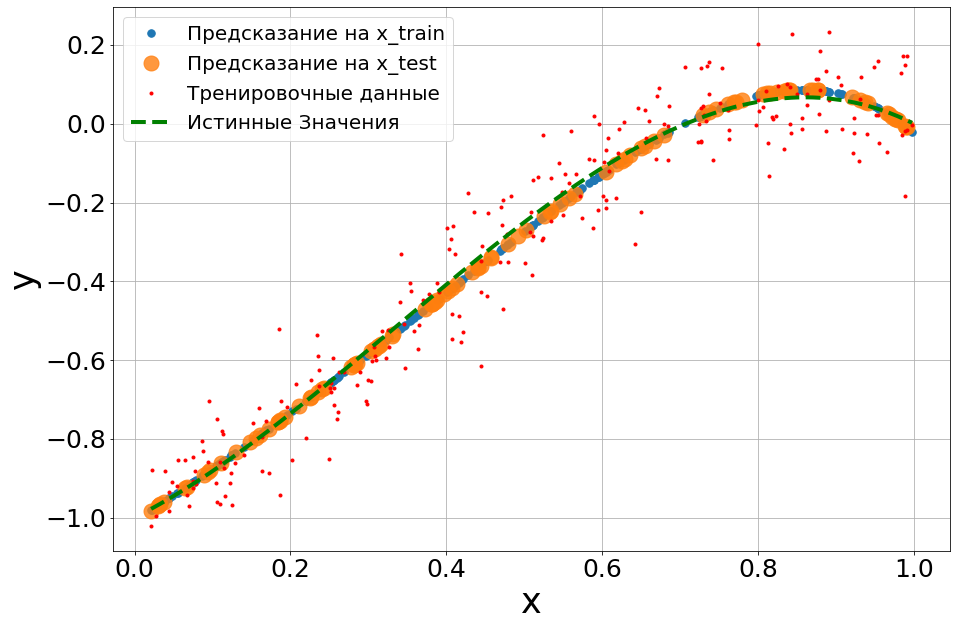

In [699]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

Для увеличения точности в предсказании для гармонических данных попробуем увеличить размер выборки.

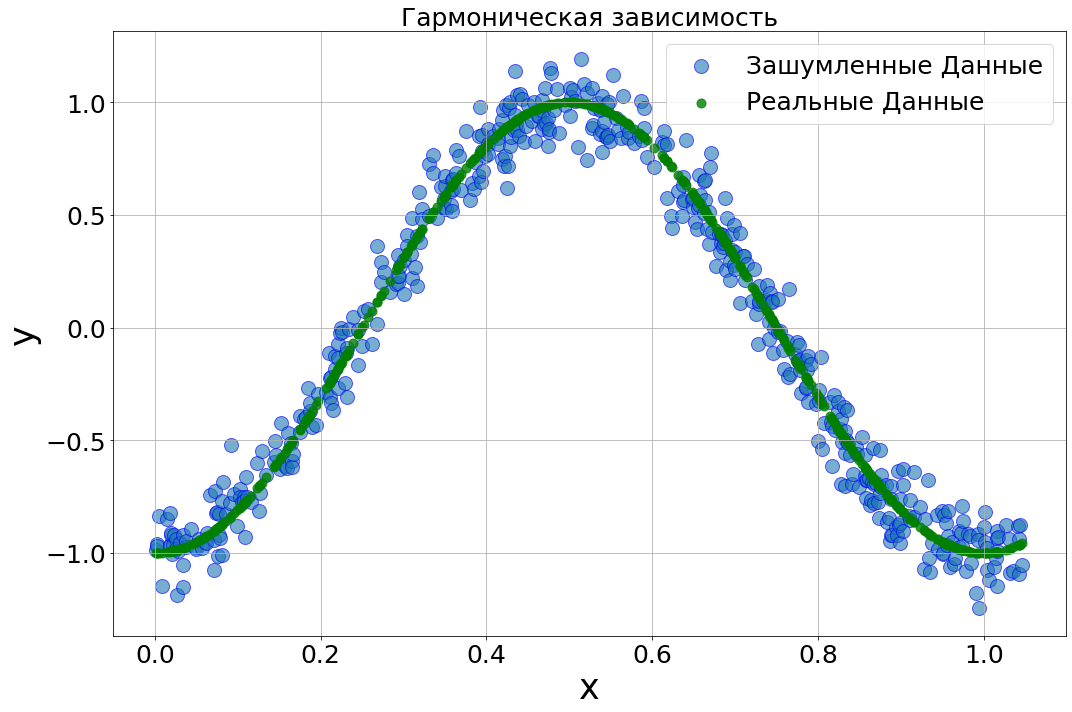

In [700]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,
                       N = 500, x_max =np.pi/3,
                       noise_power = 0.1, seed = 52)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [701]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

(350, 1) (350,) (150, 1) (150,)


Train Score = -0.09


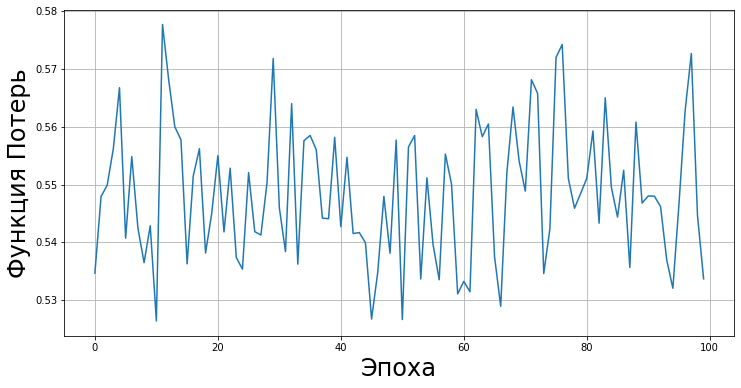

In [702]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

In [703]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[-0.22270078] 0.3137499320727055


Увеличим степень полинома до 10

In [704]:
order  = 10

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)

pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
346,0.687687,0.472913,0.325216,0.223647,0.153799,0.105765,7.273353e-02,5.001788e-02,3.439664e-02,2.365411e-02
347,0.184447,0.034021,0.006275,0.001157,0.000213,0.000039,7.262710e-06,1.339584e-06,2.470820e-07,4.557350e-08
348,0.115326,0.013300,0.001534,0.000177,0.000020,0.000002,2.713315e-07,3.129168e-08,3.608755e-09,4.161847e-10
349,0.143825,0.020686,0.002975,0.000428,0.000062,0.000009,1.273026e-06,1.830928e-07,2.633329e-08,3.787381e-09


Проводим линейную регрессию

Test Score = 0.94, Train Score = 0.94


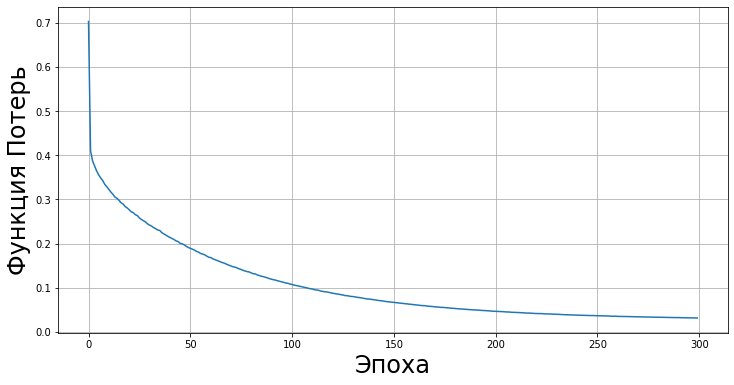

In [705]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [706]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 4.97783609 -0.41089488 -2.32225093 -2.31029269 -2.30542563 -1.45141743
  0.03200747  0.64293956  1.04204497  2.06794154] -1.0841504357318243


Добавим скейлеры данных

In [707]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [708]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [709]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

Посмотрим результат работы

In [710]:
pd.DataFrame(x_test_scaled).tail()

,0,1,2,3,4,5,6,7,8,9
145,0.392448,0.158281,-0.047196,-0.199506,-0.302398,-0.366028,-0.400930,-0.416026,-0.418157,-0.412253
146,-0.965619,-0.987116,-0.886699,-0.783545,-0.698894,-0.631441,-0.576911,-0.531876,-0.493988,-0.461657
147,1.011562,1.020861,0.936737,0.815538,0.682095,0.549678,0.425647,0.313748,0.215451,0.130825
148,1.548566,1.941696,2.226217,2.444523,2.612185,2.737677,2.827465,2.887132,2.921573,2.935027
149,-0.436919,-0.663151,-0.721892,-0.706732,-0.664838,-0.616809,-0.570756,-0.529324,-0.492941,-0.461230


Ещё раз протестируем линейную регрессию

Test Score = 0.95, Train Score = 0.96


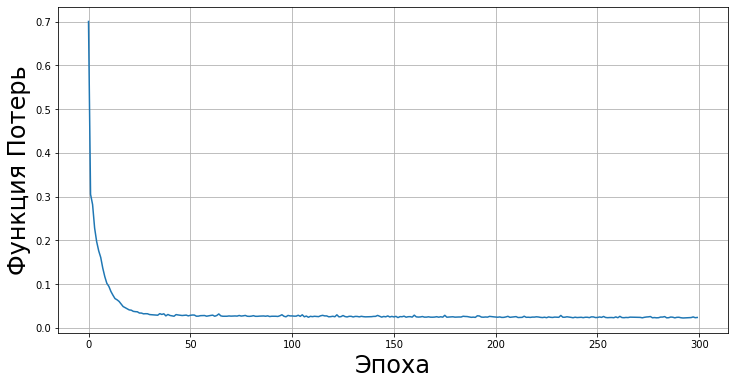

In [711]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Посмотрим полученные веса

In [712]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.92133307 -0.45323988 -1.13606396 -0.76271683 -0.83384497 -0.33145456
  0.60215462  0.51687557  0.11486404  0.26912033] -0.044089933206105214


In [713]:
np.sum(np.abs(w))

6.941667833711531

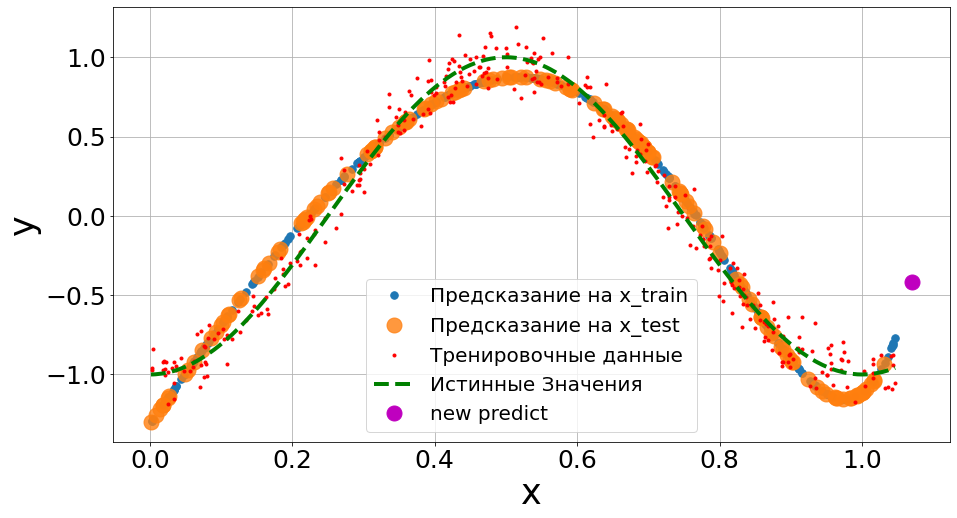

In [714]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);

###Вывод:
Результат не улучшился. Попробуем изменить степень полинома.

In [715]:
order  = 14

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
345,0.536468,0.287798,0.154394,0.082827,0.044434,0.023838,1.278807e-02,6.860385e-03,3.680375e-03,1.974402e-03,1.059203e-03,5.682281e-04,3.048360e-04,1.635347e-04
346,0.687687,0.472913,0.325216,0.223647,0.153799,0.105765,7.273353e-02,5.001788e-02,3.439664e-02,2.365411e-02,1.626662e-02,1.118634e-02,7.692697e-03,5.290166e-03
347,0.184447,0.034021,0.006275,0.001157,0.000213,0.000039,7.262710e-06,1.339584e-06,2.470820e-07,4.557350e-08,8.405889e-09,1.550440e-09,2.859737e-10,5.274695e-11
348,0.115326,0.013300,0.001534,0.000177,0.000020,0.000002,2.713315e-07,3.129168e-08,3.608755e-09,4.161847e-10,4.799706e-11,5.535327e-12,6.383691e-13,7.362079e-14
349,0.143825,0.020686,0.002975,0.000428,0.000062,0.000009,1.273026e-06,1.830928e-07,2.633329e-08,3.787381e-09,5.447195e-10,7.834419e-11,1.126784e-11,1.620595e-12


In [716]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

Test Score = 0.96, Train Score = 0.97


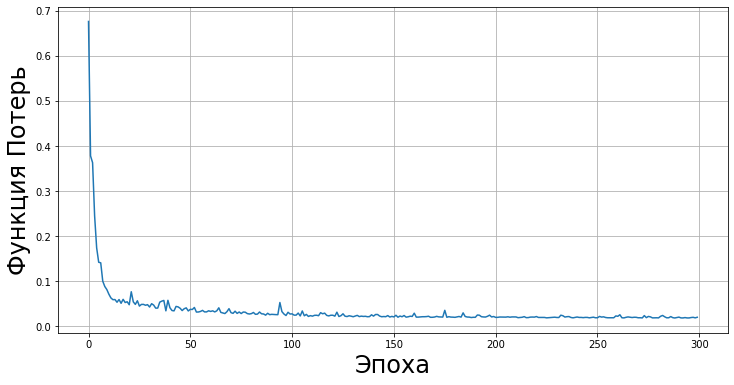

In [717]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

In [718]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.94474537 -0.35530692 -1.17261394 -0.93283812 -0.95536832 -0.42874051
  0.49535549  0.57279618  0.38634348  0.66778549  0.30104916  0.1182527
  0.06280102 -0.8018636 ] -0.043355489875188225


In [719]:
np.sum(np.abs(w))

9.195860315120639

График

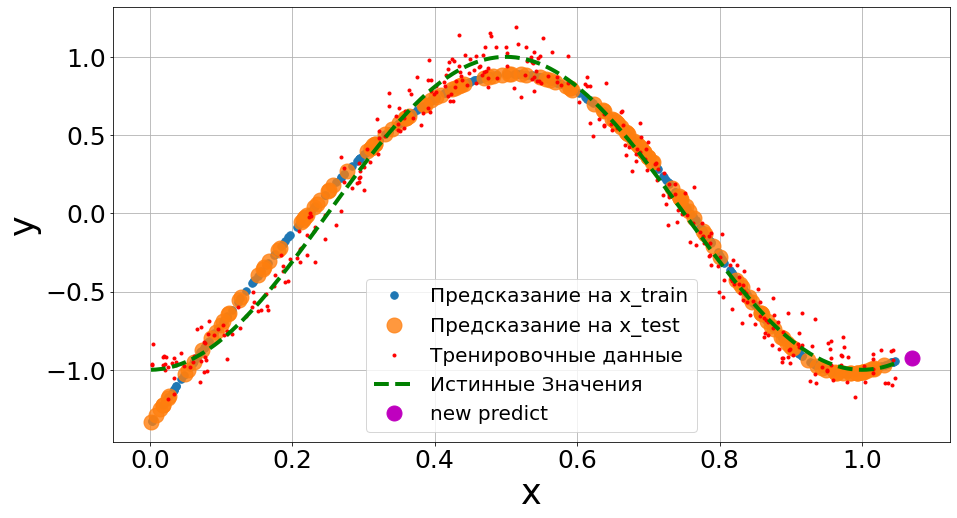

In [720]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);

### Результаты улучшились по сравнению с использованием полинома 10 степени